In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


# 모델 1 : 초기 LSTM

## lstm 초기 모델(x,y,z) - k-fold

Fold 1/5
Epoch 1/50, Loss: 1.0853, Validation Accuracy: 44.83%
Epoch 2/50, Loss: 1.0421, Validation Accuracy: 44.83%
Epoch 3/50, Loss: 1.0056, Validation Accuracy: 44.83%
Epoch 4/50, Loss: 0.9742, Validation Accuracy: 44.83%
Epoch 5/50, Loss: 0.9358, Validation Accuracy: 44.83%
Epoch 6/50, Loss: 0.8832, Validation Accuracy: 44.83%
Epoch 7/50, Loss: 0.8495, Validation Accuracy: 51.72%
Epoch 8/50, Loss: 0.7692, Validation Accuracy: 51.72%
Epoch 9/50, Loss: 0.6911, Validation Accuracy: 58.62%
Epoch 10/50, Loss: 0.6160, Validation Accuracy: 58.62%
Epoch 11/50, Loss: 0.6065, Validation Accuracy: 58.62%
Epoch 12/50, Loss: 0.5877, Validation Accuracy: 62.07%
Epoch 13/50, Loss: 0.5381, Validation Accuracy: 58.62%
Epoch 14/50, Loss: 0.6892, Validation Accuracy: 58.62%
Epoch 15/50, Loss: 0.5653, Validation Accuracy: 51.72%
Epoch 16/50, Loss: 0.5806, Validation Accuracy: 62.07%
Epoch 17/50, Loss: 0.5365, Validation Accuracy: 65.52%
Epoch 18/50, Loss: 0.6273, Validation Accuracy: 62.07%
Epoch 19/5

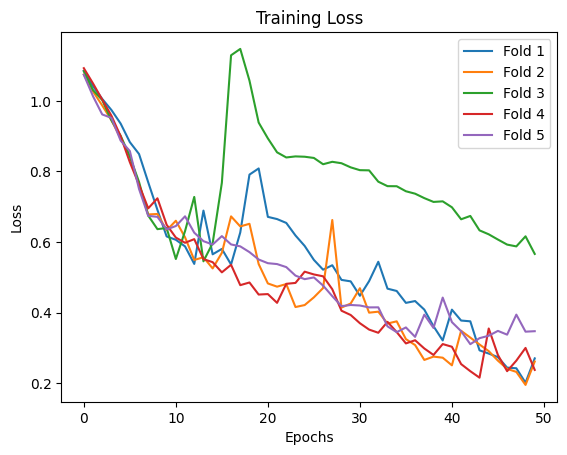

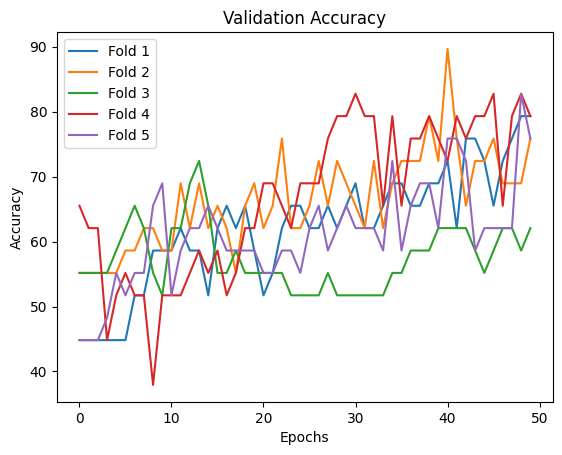

Mean Validation Accuracy: 62.80%


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pickle
import random

# 랜드마크 데이터 경로 설정
data_directory = '/content/drive/MyDrive/DL/output_all/mediapipe/processed_csvs'

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(50)  # 시드 값을 50으로 설정

# 데이터 전처리 함수
def load_and_preprocess_data(data_directory, max_len=100):
    all_data = []
    all_labels = []
    for filename in os.listdir(data_directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_directory, filename)
            df = pd.read_csv(filepath)

            # 파일 이름에서 행동 라벨 추출
            if 'broken' in filename:
                label = 'broken'
            elif 'purchase' in filename:
                label = 'purchase'
            elif 'theft' in filename:
                label = 'theft'
            else:
                continue

            # x, y, z 컬럼 추출
            columns = [f'landmark_{i}_{coord}' for i in range(33) for coord in ['x', 'y', 'z']]
            data = df[columns].values

            # 데이터 패딩 또는 자르기
            if len(data) < max_len:
                padding = np.zeros((max_len - len(data), data.shape[1]))
                data = np.vstack((data, padding))
            elif len(data) > max_len:
                data = data[:max_len]

            all_data.append(data)
            all_labels.append(label)

    return np.array(all_data), np.array(all_labels)

# 데이터 로드 및 전처리
sequences, seq_labels = load_and_preprocess_data(data_directory)

# 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(seq_labels)

# 데이터셋 클래스 정의
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 모델 정의
class SkeletonLSTM(nn.Module):
    def __init__(self, input_size=99, hidden_size=64, num_layers=2, num_classes=3):  # input_size=33*3 (x, y, z)
        super(SkeletonLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 모델, 손실 함수 및 옵티마이저 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

# 학습 함수
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 평가 함수
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# K-Fold 교차 검증 설정
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=50)

# 손실 값 및 정확도 기록을 위한 리스트 초기화
fold_train_losses = []
fold_val_accuracies = []
fold_val_accuracy_means = []

for fold, (train_idx, val_idx) in enumerate(kf.split(sequences)):
    print(f'Fold {fold+1}/{k_folds}')

    train_sequences, val_sequences = sequences[train_idx], sequences[val_idx]
    train_labels, val_labels = encoded_labels[train_idx], encoded_labels[val_idx]

    train_dataset = MyDataset(train_sequences, train_labels)
    val_dataset = MyDataset(val_sequences, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    model = SkeletonLSTM(hidden_size=64, num_layers=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    fold_train_loss = []
    fold_val_accuracy = []
    for epoch in range(50):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_accuracy = evaluate_model(model, val_loader, device)

        fold_train_loss.append(train_loss)
        fold_val_accuracy.append(val_accuracy)

        print(f'Epoch {epoch+1}/50, Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    fold_train_losses.append(fold_train_loss)
    fold_val_accuracies.append(fold_val_accuracy)
    fold_val_accuracy_means.append(np.mean(fold_val_accuracy))

# 손실 값 그래프 그리기
for fold in range(k_folds):
    plt.plot(fold_train_losses[fold], label=f'Fold {fold+1}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# 정확도 그래프 그리기
for fold in range(k_folds):
    plt.plot(fold_val_accuracies[fold], label=f'Fold {fold+1}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 평균 검증 정확도 출력
mean_val_accuracy = np.mean(fold_val_accuracy_means)
print(f'Mean Validation Accuracy: {mean_val_accuracy:.2f}%')

# 디렉토리가 없으면 생성
model_dir = '/content/drive/MyDrive/DL/models_all'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 모델 저장 (마지막 fold의 모델 저장)
torch.save(model.state_dict(), os.path.join(model_dir, 'lstm_behavior_model_xyz.pth'))

# 라벨 인코더 저장
with open(os.path.join(model_dir, 'label_encoder_xyz.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)


Test Accuracy: 77.14%
Classification Report:
              precision    recall  f1-score   support

      broken       0.75      0.50      0.60        12
    purchase       0.85      1.00      0.92        11
       theft       0.71      0.83      0.77        12

    accuracy                           0.77        35
   macro avg       0.77      0.78      0.76        35
weighted avg       0.77      0.77      0.76        35

Confusion Matrix:
[[ 6  2  4]
 [ 0 11  0]
 [ 2  0 10]]


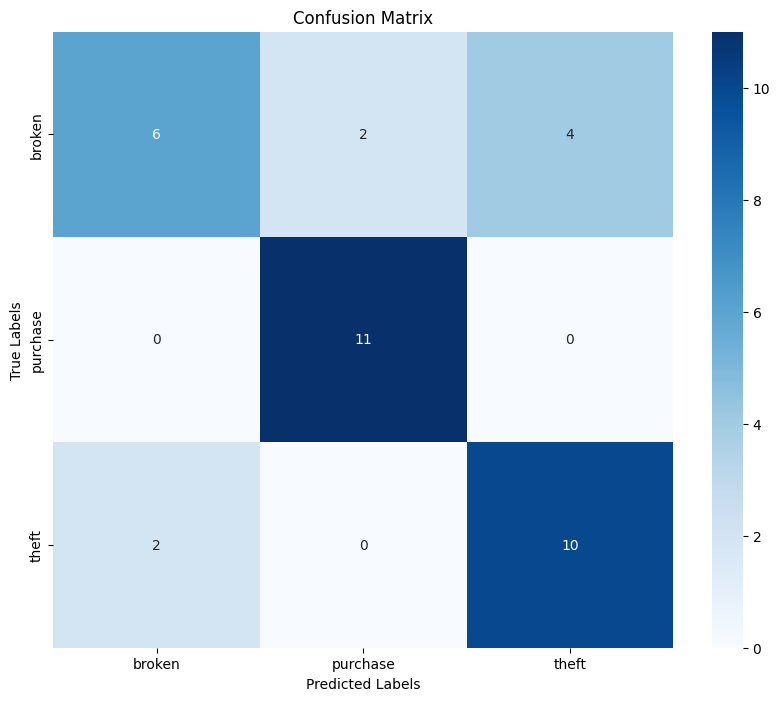

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 로드
best_model = SkeletonLSTM(hidden_size=64, num_layers=2).to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/DL/models_all/lstm_behavior_model_xyz.pth'))
best_model.eval()

# 라벨 인코더 로드
with open('/content/drive/MyDrive/DL/models_all/label_encoder_xyz.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# 최종 테스트 평가
test_data_directory = "/content/drive/MyDrive/DL/output_all/mediapipe/test_csvs"  # 테스트 데이터 디렉토리 경로 지정
test_sequences, test_labels = load_and_preprocess_data(test_data_directory)
encoded_test_labels = label_encoder.transform(test_labels)
test_data = MyDataset(test_sequences, encoded_test_labels)
test_loader = DataLoader(test_data, batch_size=32)
test_accuracy = evaluate_model(best_model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# 실제값과 예측값 저장 리스트 초기화
all_labels = []
all_predictions = []

# 모델 예측 수행
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = best_model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 실제 라벨과 예측 라벨을 디코딩
all_labels = label_encoder.inverse_transform(all_labels)
all_predictions = label_encoder.inverse_transform(all_predictions)

# classification report 출력
print("Classification Report:")
print(classification_report(all_labels, all_predictions))

# confusion matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix 생성
cm = confusion_matrix(all_labels, all_predictions)
labels = label_encoder.classes_

# Confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()